In [34]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt
from google.colab import drive

In [35]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [36]:
train_text = pd.read_csv('/content/drive/MyDrive/coen342/pr3/train.dat', sep="\n", names=['Text'])
print(train_text)

                                                    Text
0      THE BRAIN THAT WOULDN'T DIE was considered so ...
1      To qualify my use of "realistic" in the summar...
2      The Hebrew Hammer is a clever idea wasted, as ...
3      Generally I like something light and fun, so t...
4      My room-mate ordered this one off of the web a...
...                                                  ...
24995  Moonwalker is absolutely incredible !!!!!!! Wh...
24996  I saw One Life Stand when it premiered at the ...
24997  this is awesome!!! there is no partnership qui...
24998  When I started watching this, I instantly noti...
24999  This movie has taken a lot of stick. It was sl...

[25000 rows x 1 columns]


In [37]:
sentiment = pd.read_csv('/content/drive/MyDrive/coen342/pr3/train.labels', sep="\n", names=['Sentiment'])
print(sentiment)

       Sentiment
0              1
1              1
2             -1
3              1
4              1
...          ...
24995          1
24996          1
24997          1
24998         -1
24999          1

[25000 rows x 1 columns]


In [38]:
train = train_text.join(sentiment['Sentiment'].replace({-1: 0}))

In [39]:
print(train)

                                                    Text  Sentiment
0      THE BRAIN THAT WOULDN'T DIE was considered so ...          1
1      To qualify my use of "realistic" in the summar...          1
2      The Hebrew Hammer is a clever idea wasted, as ...          0
3      Generally I like something light and fun, so t...          1
4      My room-mate ordered this one off of the web a...          1
...                                                  ...        ...
24995  Moonwalker is absolutely incredible !!!!!!! Wh...          1
24996  I saw One Life Stand when it premiered at the ...          1
24997  this is awesome!!! there is no partnership qui...          1
24998  When I started watching this, I instantly noti...          0
24999  This movie has taken a lot of stick. It was sl...          1

[25000 rows x 2 columns]


In [40]:
train.head(10)

,Text,Sentiment
0,THE BRAIN THAT WOULDN'T DIE was considered so ...,1
1,"To qualify my use of ""realistic"" in the summar...",1
2,"The Hebrew Hammer is a clever idea wasted, as ...",0
3,"Generally I like something light and fun, so t...",1
4,My room-mate ordered this one off of the web a...,1
5,"Okay, some other people have commented that th...",0
6,"Seriously, I can easily stomach a lot of on sc...",0
7,I found Dominion to be a lousy attempt to cont...,0
8,This was a truly insipid film. The performance...,0
9,You could stage a version of Charles Dickens' ...,1


In [41]:
train['Sentiment'].value_counts()

1    12500
0    12500
Name: Sentiment, dtype: int64

In [42]:
def text_cleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'@[A-Za-zA-Z0-9]+','',text)
    text = re.sub(r'@[A-Za-z]+','',text)
    text = re.sub(r'@[-)]+','',text)
    text = re.sub(r'#','',text)
    text = re.sub(r'RT[\s]+','',text)
    text = re.sub(r'https?\/\/\S+','',text)
    text = re.sub(r'<br />','',text)
    
    return text

In [43]:
train['Text'] = train['Text'].apply(text_cleaning)
train.head(10)

,Text,Sentiment
0,THE BRAIN THAT WOULDN'T DIE was considered so ...,1
1,"To qualify my use of ""realistic"" in the summar...",1
2,"The Hebrew Hammer is a clever idea wasted, as ...",0
3,"Generally I like something light and fun, so t...",1
4,My room-mate ordered this one off of the web a...,1
5,"Okay, some other people have commented that th...",0
6,"Seriously, I can easily stomach a lot of on sc...",0
7,I found Dominion to be a lousy attempt to cont...,0
8,This was a truly insipid film. The performance...,0
9,You could stage a version of Charles Dickens' ...,1


In [44]:
x_train, x_val, y_train, y_val = train_test_split(train['Text'].values, train['Sentiment'].values, test_size=0.30)

In [45]:
print('Text: ', x_train[0])
print('Sentiment: ', y_train[0])

Text:  I loved this film. Not being a swooning Ed Wood Jr. fan, I prefer to appreciate his "boundless enthusiasm" and acknowledge his shortcomings. His movies are fun, but his personal story is one racked with pain. I hoped, and was delighted to find, that this film would be about understanding his turbulent life, rather than simply heaping him with posthumous praise. From beginning to end, this film evolves from a documentary into a mythology, leaving the cast and the viewer unexpectedly connected to each other and to Ed Wood Jr.What we get are people who knew Ed Wood the best talking about him from all perspectives, positive and negative, and showing us their character as much as Ed's. We get insight into Ed's personal and professional life: from his romances, to his drinking, to his sexuality, to his friends, to his enemies, and even to his film making.The film itself is shot in a low-budget way that seems done out of respect for Ed, as if using the techniques of most theatrically r

In [46]:
max_vocab = 200000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

In [47]:
wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of dataset vocab is: ', V)

The size of dataset vocab is:  77811


In [48]:
train_seq = tokenizer.texts_to_sequences(x_train)
val_seq = tokenizer.texts_to_sequences(x_val)
print('Training sequence: ', train_seq[0])
print('Validation sequence: ', val_seq[0])

Training sequence:  [9, 407, 10, 18, 20, 111, 3, 29158, 1350, 1908, 1636, 328, 9, 2506, 5, 1103, 23, 15532, 4708, 2, 6514, 23, 5613, 23, 94, 22, 242, 17, 23, 935, 59, 6, 26, 29159, 16, 1427, 9, 3249, 2, 12, 7501, 5, 163, 11, 10, 18, 57, 25, 40, 2001, 23, 9789, 113, 252, 70, 337, 22707, 83, 16, 34713, 2536, 36, 452, 5, 126, 10, 18, 10459, 36, 3, 615, 80, 3, 7502, 1186, 1, 174, 2, 1, 528, 5015, 3405, 5, 253, 84, 2, 5, 1350, 1908, 1636, 47, 72, 76, 22, 77, 33, 683, 1350, 1908, 1, 114, 658, 40, 83, 36, 28, 8478, 1155, 2, 1472, 2, 751, 180, 60, 106, 13, 71, 13, 20712, 72, 76, 2471, 80, 20712, 935, 2, 1656, 113, 36, 23, 6266, 5, 23, 2622, 5, 23, 3081, 5, 23, 364, 5, 23, 4006, 2, 54, 5, 23, 18, 227, 1, 18, 391, 6, 308, 7, 3, 344, 324, 96, 11, 186, 221, 43, 4, 1156, 15, 1350, 13, 41, 759, 1, 3516, 4, 87, 11699, 597, 94, 36, 4099, 57, 25, 12217, 435, 4, 34, 1625, 3, 10838, 2007, 70, 1, 1829, 1, 254, 5614, 1145, 3, 287, 4, 439, 2, 86, 3, 74, 756, 4, 2471, 50, 10839, 253, 174, 1660, 16, 60, 948, 

In [49]:
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

The length of training sequence is:  1841


In [50]:
pad_val = pad_sequences(val_seq, maxlen=T)
print('The length of the valdidation sequence is: ', pad_val.shape[1])

The length of the valdidation sequence is:  1841


In [51]:
D = 20
M = 15

In [52]:
i = Input (shape=(T, ))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='tanh')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
r = model.fit(pad_train, y_train, validation_data=(pad_val, y_val), epochs=10)

246/547 [============>.................] - ETA: 4:04 - loss: 0.0130 - accuracy: 0.9978

KeyboardInterrupt: ignored

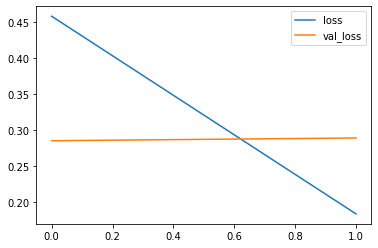

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

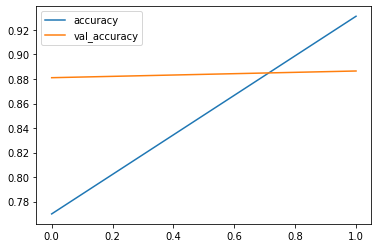

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
model.save('sentiment analysis.h5')

In [ ]:
test_text = pd.read_csv('/content/drive/MyDrive/coen342/pr3/test.dat', sep="\n", names=['Text'])
test_df = pd.DataFrame(test_text)
print(test_df)

                                                    Text
0      L'Humanité is a murder mystery. These movies t...
1      I watched this movie when Joe Bob Briggs hoste...
2      I didn't know it was possible to release a mov...
3      Hot Millions is a great movie in every way. A ...
4      An interesting movie with Jordana Brewster as ...
...                                                  ...
24995  I love the comics. Although I do have problems...
24996  Geez! This is one of those movies that you thi...
24997  Truly unique and stunning film of Jules Verne'...
24998  tell you what that was excellent. Dylan Moran ...
24999  While not as bad as his game-to-movie adaptati...

[25000 rows x 1 columns]


In [ ]:
test_df['Text'] = test_df['Text'].apply(text_cleaning)

In [ ]:
print(test_df)

                                                    Text
0      L'Humanité is a murder mystery. These movies t...
1      I watched this movie when Joe Bob Briggs hoste...
2      I didn't know it was possible to release a mov...
3      Hot Millions is a great movie in every way. A ...
4      An interesting movie with Jordana Brewster as ...
...                                                  ...
24995  I love the comics. Although I do have problems...
24996  Geez! This is one of those movies that you thi...
24997  Truly unique and stunning film of Jules Verne'...
24998  tell you what that was excellent. Dylan Moran ...
24999  While not as bad as his game-to-movie adaptati...

[25000 rows x 1 columns]


In [ ]:
predictions = []
def predict_sentiment(text):
    text_seq = tokenizer.texts_to_sequences(text)
    text_pad = pad_sequences(text_seq, maxlen=T)
    predicted_sentiment = model.predict(text_pad).round()
    if predicted_sentiment == 1.0:
        file_object.write('+1\n')
    else:
        file_object.write('-1\n')


In [ ]:
row_1=test_df.iloc[1].values.tolist()
print(row_1)

["I watched this movie when Joe Bob Briggs hosted Monstervision on TNT. Even he couldn't make this movie enjoyable. The only reason I watched it until the end is because I teach video production and I wanted to make sure my students never made anything this bad ... but it took all my intestinal fortitude to sit through it though. It's like watching your great grandmother flirting with a 15 year old boy ... excruciatingly painful.If you took the actual film, dipped it in paint thinner, then watched it, it would be more entertaining. Seriously.If you see this movie in the bargin bin at S-Mart, back away from it as if it were a rattlesnake."]


In [ ]:
# Open a file with access mode 'a'
file_object = open('sample.txt', 'a')
# Append 'hello' at the end of file
file_object.write('hello')
# Close the file
file_object.close()

In [ ]:
N = test_df.count()[0]
print(N)

25000


In [ ]:
file_object = open('predictions1.txt', 'a')
for i in range(N):
    row_i=test_df.iloc[i].values.tolist()
    test_sentiment = np.array(predict_sentiment(row_i))
file_object.close()

In [ ]:
#text_seq = tokenizer.texts_to_sequences(row_1)
#text_pad = pad_sequences(text_seq, maxlen=T)
#predicted_sentiment = model.predict(text_pad).round()
#print(test_sentiment)

NameError: ignored

In [ ]:
N = test_df.count()[0]
print(N)

25000


In [ ]:
M = 10
for i in range(M):
    row_i=test_df.iloc[i].values.tolist()
    test_sentiment = np.array(predict_sentiment(row_i))
    #np.savetxt('/content/test.txt' %test_sentiment, fmt='%s', newline='\n')
    #print(test_sentiment)
    #np.savetxt('/content/prediction.txt' test_sentiment, fmt='%s', newline='\n')
    #file = pd.read_csv('/content/prediction.txt', names=['Sentiment'])
#type(test_sentiment)
#print(test_sentiment)
#np.savetxt('/content/test.txt', test_sentiment, fmt='%d', newline='\n')

ValueError: ignored